In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

In [2]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [5]:
# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

In [7]:
# Initialize the model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training loop
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{n_epochs}, Average Training Loss: {avg_train_loss:.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/5, Average Training Loss: 0.1605
Epoch 2/5, Average Training Loss: 0.0534
Epoch 3/5, Average Training Loss: 0.0376
Epoch 4/5, Average Training Loss: 0.0291
Epoch 5/5, Average Training Loss: 0.0245


In [9]:

# Evaluation
model.eval()
test_loss = 0
correct = 0
y_pred = []
y_true = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        y_pred.extend(pred.view(-1).cpu().numpy())
        y_true.extend(target.cpu().numpy())

test_loss /= len(test_loader)
accuracy = 100. * correct / len(test_loader.dataset)

print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)


Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)
Confusion Matrix:
[[ 977    0    0    1    0    0    1    0    1    0]
 [   0 1134    0    1    0    0    0    0    0    0]
 [   1    0 1023    2    1    0    0    4    1    0]
 [   0    0    0 1007    0    2    0    0    1    0]
 [   0    0    0    0  971    0    1    0    1    9]
 [   1    1    0    4    0  883    3    0    0    0]
 [   4    2    0    0    1    1  948    0    2    0]
 [   0    2    5    3    0    0    0 1014    1    3]
 [   3    0    2    1    0    1    0    1  964    2]
 [   0    0    0    1    3    5    0    2    2  996]]


Confusion Matrix:
[[ 977    0    0    1    0    0    1    0    1    0]
 [   0 1134    0    1    0    0    0    0    0    0]
 [   1    0 1023    2    1    0    0    4    1    0]
 [   0    0    0 1007    0    2    0    0    1    0]
 [   0    0    0    0  971    0    1    0    1    9]
 [   1    1    0    4    0  883    3    0    0    0]
 [   4    2    0    0    1    1  948    0    2    0]
 [   0    2    5    3    0    0    0 1014    1    3]
 [   3    0    2    1    0    1    0    1  964    2]
 [   0    0    0    1    3    5    0    2    2  996]]


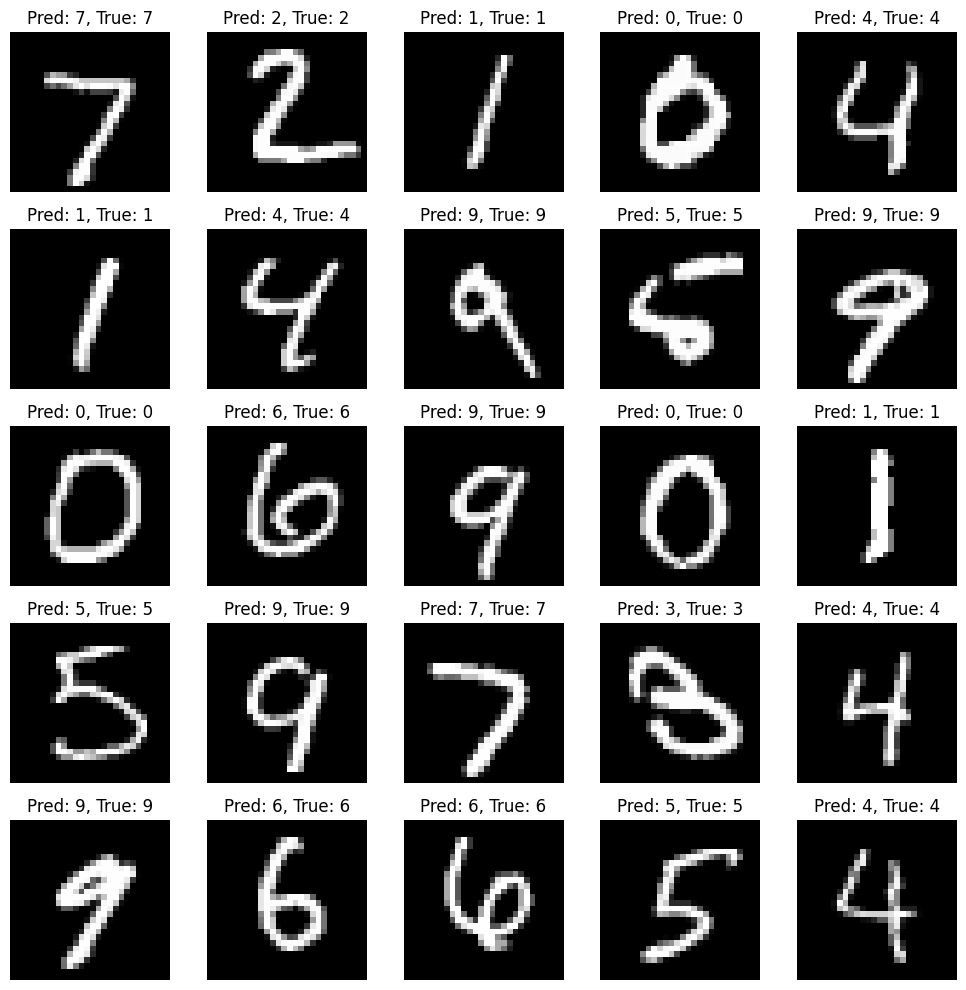

In [10]:
conf_mat = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_mat)

fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    ax[i//5, i%5].imshow(test_dataset[i][0].squeeze(), cmap='gray')
    ax[i//5, i%5].set_title(f'Pred: {y_pred[i]}, True: {y_true[i]}')
    ax[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()


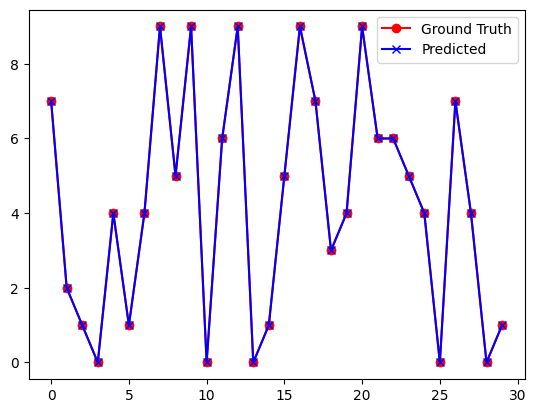

In [11]:
plt.plot(range(30), y_true[:30], color='r', label='Ground Truth', linestyle='-', marker='o')
plt.plot(range(30), y_pred[:30], color='b', label='Predicted', linestyle='-', marker='x')
plt.legend()
plt.show()
